# Tools and Processes for Machine Learning and Data Analysis
 
### Goal

You have two tasks: 1) recap the training flow of a neural network and 2) use a traking tool to control this flow. 

### Submission
Your are asked to implement a neural network to classify if there is a person with blond hairs on a photo and generate `submission.csv` for the test set.

## Frameworks we're using in this lab

#### PyTorch
   PyTorch is an open-source machine learning library primarily developed by Meta's (компания признана экстремистской организацией на территории Российской Федерации) AI Research lab . It is widely used for deep learning tasks.

#### Tensorboard
   TensorBoard is a visualization tool provided by TensorFlow for monitoring and visualizing the training process and model performance during machine learning experiments.


#### ClearML
   ClearML is an open-source machine learning platform designed to automate and streamline the end-to-end machine learning workflow, including data management, model training, and deployment.

In [1]:
# We will use tensorboard as logging tool. However kaggle does not allow to view it.
# !pip install tensorboard

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 1. Data set

Data set, a part of [CelebA](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/data), contain about 11,000 cropped images of faces. Your task is to detect people with blond hairs or do binary classification (blondy\not blondy) for each image.

There are several small challenges you're going to face with the dataset. First, the images are much bigger than in regular learning sets—178 by 218 pixels in RGB scale. Second, the CelebA dataset is quite well- labelled, and each image has lots of metadata about face features. Usually, they are used to train generative or face recognition models. We intentionally left all of these features, which are redundant for solving this task.

Please do not train a classifier on other data than given (including other parts of CelebA).


## 1.1 Data preprocessing

In [3]:
# necessary imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms as transforms
from torchvision.io import read_image

In [4]:

def load_img(fname):
    """
    Load an image from file, do transformation (including possible augmentation) and return it as torch.tensor

    :param fname: path to jpg image
    """
    img = read_image(fname)
    x = img / 255.
#     print(type(x))
    # Write your code here
    transform = transforms.Compose(
        [
                transforms.Resize((32,32)),
#                 transforms.RandomResizedCrop(size=(224, 224), antialias=True),
                transforms.RandomHorizontalFlip(p=0.5),
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            #   Here you can add more augmentations.
            #   See documentation: https://pytorch.org/vision/stable/transforms.html
        ]
    )

    return transform(x)

In [5]:
img_path = "/kaggle/input/pmldl-week-2-dnn-training-with-tracking-tools/archive"

# Image attributes
train_features = pd.read_csv(f"{img_path}/train.csv")
train_features['Blond_Hair'].describe()

count    11785.000000
mean        -0.469325
std          0.883063
min         -1.000000
25%         -1.000000
50%         -1.000000
75%          1.000000
max          1.000000
Name: Blond_Hair, dtype: float64

In [33]:
img_path = "/kaggle/input/pmldl-week-2-dnn-training-with-tracking-tools/archive"

# Image attributes
train_features = pd.read_csv(f"{img_path}/train.csv")

# Load and transform images 
images = torch.stack([load_img(f"{img_path}/img_align_celeba/train/{item['image_id']}") for _, item in  train_features.iterrows()])

# Write your code here
# Select label(s) from train_features
labels = train_features['Blond_Hair']
# Leave values that only 1 or 0 and convert to float just for simplicity
labels.replace(-1, 0, inplace=True)
labels = torch.from_numpy(labels.to_numpy()).float()


In [37]:
sum(labels == 0)

tensor(8658)

In [7]:
# Just some checking of shapes
images.shape, labels.shape

(torch.Size([11785, 3, 32, 32]), torch.Size([11785]))

In [8]:
images[0]

tensor([[[0.8608, 0.8496, 0.8520,  ..., 0.9148, 0.9158, 0.9155],
         [0.8606, 0.8497, 0.8512,  ..., 0.9167, 0.9150, 0.9155],
         [0.8613, 0.8523, 0.8509,  ..., 0.9139, 0.9123, 0.9137],
         ...,
         [0.8138, 0.7793, 0.7491,  ..., 0.8756, 0.8908, 0.8901],
         [0.8077, 0.8107, 0.7924,  ..., 0.8684, 0.8858, 0.8959],
         [0.8701, 0.8674, 0.8324,  ..., 0.8548, 0.8776, 0.8883]],

        [[0.8569, 0.8457, 0.8481,  ..., 0.9070, 0.9079, 0.9077],
         [0.8566, 0.8458, 0.8472,  ..., 0.9088, 0.9071, 0.9076],
         [0.8574, 0.8483, 0.8469,  ..., 0.9060, 0.9044, 0.9058],
         ...,
         [0.7440, 0.6587, 0.5768,  ..., 0.7127, 0.7299, 0.7316],
         [0.6044, 0.5995, 0.5816,  ..., 0.6891, 0.7123, 0.7276],
         [0.6470, 0.6538, 0.6382,  ..., 0.6355, 0.6686, 0.6879]],

        [[0.8491, 0.8378, 0.8403,  ..., 0.9109, 0.9119, 0.9116],
         [0.8488, 0.8379, 0.8394,  ..., 0.9127, 0.9111, 0.9116],
         [0.8496, 0.8405, 0.8391,  ..., 0.9099, 0.9083, 0.

## 1.2 Visualization

In [9]:
import matplotlib.pyplot as plt


def plot_images(images, captions=[], rows=2, columns=5, title="", **kwargs):
    """
    Plots images with captions

    :param images: list of images to plot
    :param captions: captions of images:
    :param rows: number of rows in figure
    :param columns: number of columns:
    :param title: super title of figure
    """
    fig = plt.figure(figsize=(6, 3))
    for i, img in enumerate(images):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(img, **kwargs)
        if i < len(captions):
            plt.title(captions[i])
        plt.axis("off")
    fig.suptitle(title)
    plt.show()

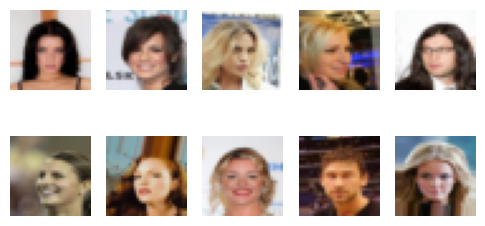

In [10]:
# Visualise 10 images from the dataset
plot_images(images[:10].permute((0, 2, 3, 1)), cmap="gray")


## 1.3 Data loaders creation

In [11]:
from torch.utils.data import TensorDataset, DataLoader

processed_dataset = TensorDataset(images, labels)

# Write your code here
# Set proportion and split dataset into train and validation parts
proportion = 0.8

train_dataset, val_dataset = torch.utils.data.random_split(
    processed_dataset,
   [(int(len(images) * proportion)), len(images) - int(len(images) * proportion)],
)

# train_dataset = train_dataset.type(torch.LongTensor)
# val_dataset = val_dataset.type(torch.LongTensor)

In [12]:
# Create Dataloaders for training and validation 
# Dataloader is iterable object over dataset
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


## 2. Training


## 2.1 Defining a model

We will implement CNN

> if you want higher score implement any suitable model you know and like

Check Pytorch [documentation](https://pytorch.org/docs/stable/nn.html): layers, loss functions, etc

In [107]:
import torch.nn as nn
import torch.nn.functional as F
class CNNClassificationModel(nn.Module):
    """
    CNN (convolutional neural network) based classification model

    param num_classes: number of classed you defined at preprocessing step
    """

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
#         m = nn.Softmax(dim=1)
#         x = m(x)
        return x
model = CNNClassificationModel()

## 2.2 Defining training & validation loops

Here is the sample function for training procedure. 
We save the checkpoints with best accuracy score. For the inference you need to load it to the model.

> You can add early stopping if you want for better results

In [126]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.3)
for epoch in range(12):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#         print(type(labels))
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        outputs = outputs.float()
        labels = labels.long()
#         print(type(outputs))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 40 == 39:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    40] loss: 0.001
[1,    80] loss: 0.001
[1,   120] loss: 0.001
[2,    40] loss: 0.001
[2,    80] loss: 0.001
[2,   120] loss: 0.001
[3,    40] loss: 0.001
[3,    80] loss: 0.001
[3,   120] loss: 0.001
[4,    40] loss: 0.001
[4,    80] loss: 0.001
[4,   120] loss: 0.001
[5,    40] loss: 0.001
[5,    80] loss: 0.001
[5,   120] loss: 0.001
[6,    40] loss: 0.001
[6,    80] loss: 0.001
[6,   120] loss: 0.001
[7,    40] loss: 0.001
[7,    80] loss: 0.001
[7,   120] loss: 0.001
[8,    40] loss: 0.001
[8,    80] loss: 0.001
[8,   120] loss: 0.001
[9,    40] loss: 0.001
[9,    80] loss: 0.001
[9,   120] loss: 0.001
[10,    40] loss: 0.001
[10,    80] loss: 0.001
[10,   120] loss: 0.001
[11,    40] loss: 0.001
[11,    80] loss: 0.001
[11,   120] loss: 0.001
[12,    40] loss: 0.001
[12,    80] loss: 0.001
[12,   120] loss: 0.001
Finished Training


In [127]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 92 %


In [67]:
def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    writer=None,
    epochs=1,
    device="cpu",
    ckpt_path="best.pt",
):
    # best score for checkpointing
    best = 0.0
    
    # iterating over epochs
    for epoch in range(epochs):
        # training loop description
        train_loop = tqdm(
            enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch {epoch}"
        )
        model.train()
        train_loss = 0.0
        # iterate over dataset 
        for data in train_loop:
            # Write your code here
            # Move data to a device, do forward pass and loss calculation, do backward pass and run optimizer
#             labels, inputs = data
            labels = data[-1][-1]
            inputs = data[-1][:-1][0]
#             print(data[-1][-1])
            print(inputs.shape)
            print(labels)
            y_pred = model(inputs)
            
#             y_
            print(y_pred)
            print(labels.type())
            print(y_pred.type())
            
            loss = loss_fn(y_pred, labels)
    
            loss.backword()
            optimizer.step()
            train_loss += loss.item()
            train_loop.set_postfix({"loss": loss.item()})
        # write loss to tensorboard
        if writer:
            writer.add_scalar("Loss/train", train_loss / len(train_loader), epoch)
        
        # Validation
        correct = 0
        total = 0
        with torch.no_grad():
            model.eval()  # evaluation mode
            val_loop = tqdm(enumerate(val_loader, 0), total=len(val_loader), desc="Val")
            for data in val_loop:
                inputs, labels = data
                # Write your code here
                # Get predictions and compare them with labels
                val_loop.set_postfix({"acc": correct / total})

            if correct / total > best:
                torch.save(model.state_dict(), ckpt_path)
                best = correct / total


## 2.3 Combining everything together

In [66]:
# Write your code here
# Pick optimizer from torch.optim and loss function loss_fn from torch.nn that suits best the model
# SummaryWriter is used by tensorboard and could be set None
from torch import optim

optimizer = optim.AdamW(
    lr=1.e-5,
    betas=[0.9, 0.999],
    eps=1.e-08,
    weight_decay=1.e-2,
    params=CNNClassificationModel().parameters()
)

train(
    model=CNNClassificationModel(),
    optimizer= optimizer,
    loss_fn=  nn.CrossEntropyLoss(),
    train_loader=train_loader,
    val_loader=val_loader,
    device='cpu',
    writer=SummaryWriter(),
    epochs=2
)


Epoch 0:   0%|          | 0/148 [00:00<?, ?it/s]

torch.Size([64, 3, 32, 32])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])


NameError: name 'long' is not defined

## 2.4 Inference
Here you need to perform inference of trained model on test data. 

Load the best checkpoint from training to the model and run inference

In [ ]:
# load best checkpoint to model
model = CNNClassificationModel()
ckpt = torch.load("best.pt")
model.load_state_dict(ckpt)

In [86]:
def predict(model, test_loader, device):
    """
    Run model inference on test data
    """
    predictions = []
    with torch.no_grad():
        model.eval()  # evaluation mode
        test_loop = tqdm(enumerate(test_loader, 0), total=len(test_loader), desc="Test")
        for inputs in test_loop:
            # Write your code here
            # Similar to validation part in training cell
#             print(type(inputs[0]))
#             print(inputs[0])
            predicted = model(inputs[1])
            # Extend overall predictions by prediction for a batch
            predictions.extend(predicted)
        return predictions

def load_training_img(fname):
    img = read_image(fname)
    x = img / 255.

    transform = transforms.Compose(
        [
            transforms.Resize((32,32))
            # Write your code here
            # Do not apply data augmentation as in training function, but make sure the size of input image is the same
        ]
    )

    return transform(x) 

In [87]:
predictions[0].numpy()

array([-2.1304739,  2.0029693], dtype=float32)

In [88]:
# process test data and run inference on it
test_features = pd.read_csv(f"{img_path}/test.csv")
images = torch.stack([load_img(f"{img_path}/img_align_celeba/test/{item['image_id']}") for _, item in  test_features.iterrows()])

test_loader = DataLoader(images, batch_size=batch_size, shuffle=False)
predictions = predict(model, test_loader, device="cpu")

# generate the submission file
submission_df = pd.DataFrame(columns=['ID', 'Blond_Hair'])
submission_df['ID'] = test_features.index
submission_df['Blond_Hair'] = [np.argmax(p.numpy()) for p in predictions]
submission_df.to_csv('submission.csv', index=False)
submission_df.head()

Test:   0%|          | 0/16 [00:00<?, ?it/s]

,ID,Blond_Hair
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [91]:
len([np.argmax(p.numpy()) for p in predictions])

987

## 3 Training tracking - [ClearML](https://clear.ml/docs/latest/docs/getting_started/ds/ds_first_steps/) or Tensorboard

In [18]:
# Kaggle has no support of viewing tensorboard. Run this if you are using your machine
# to see logs.
# !tensorboard --logdir . 

Tensorboard should like this
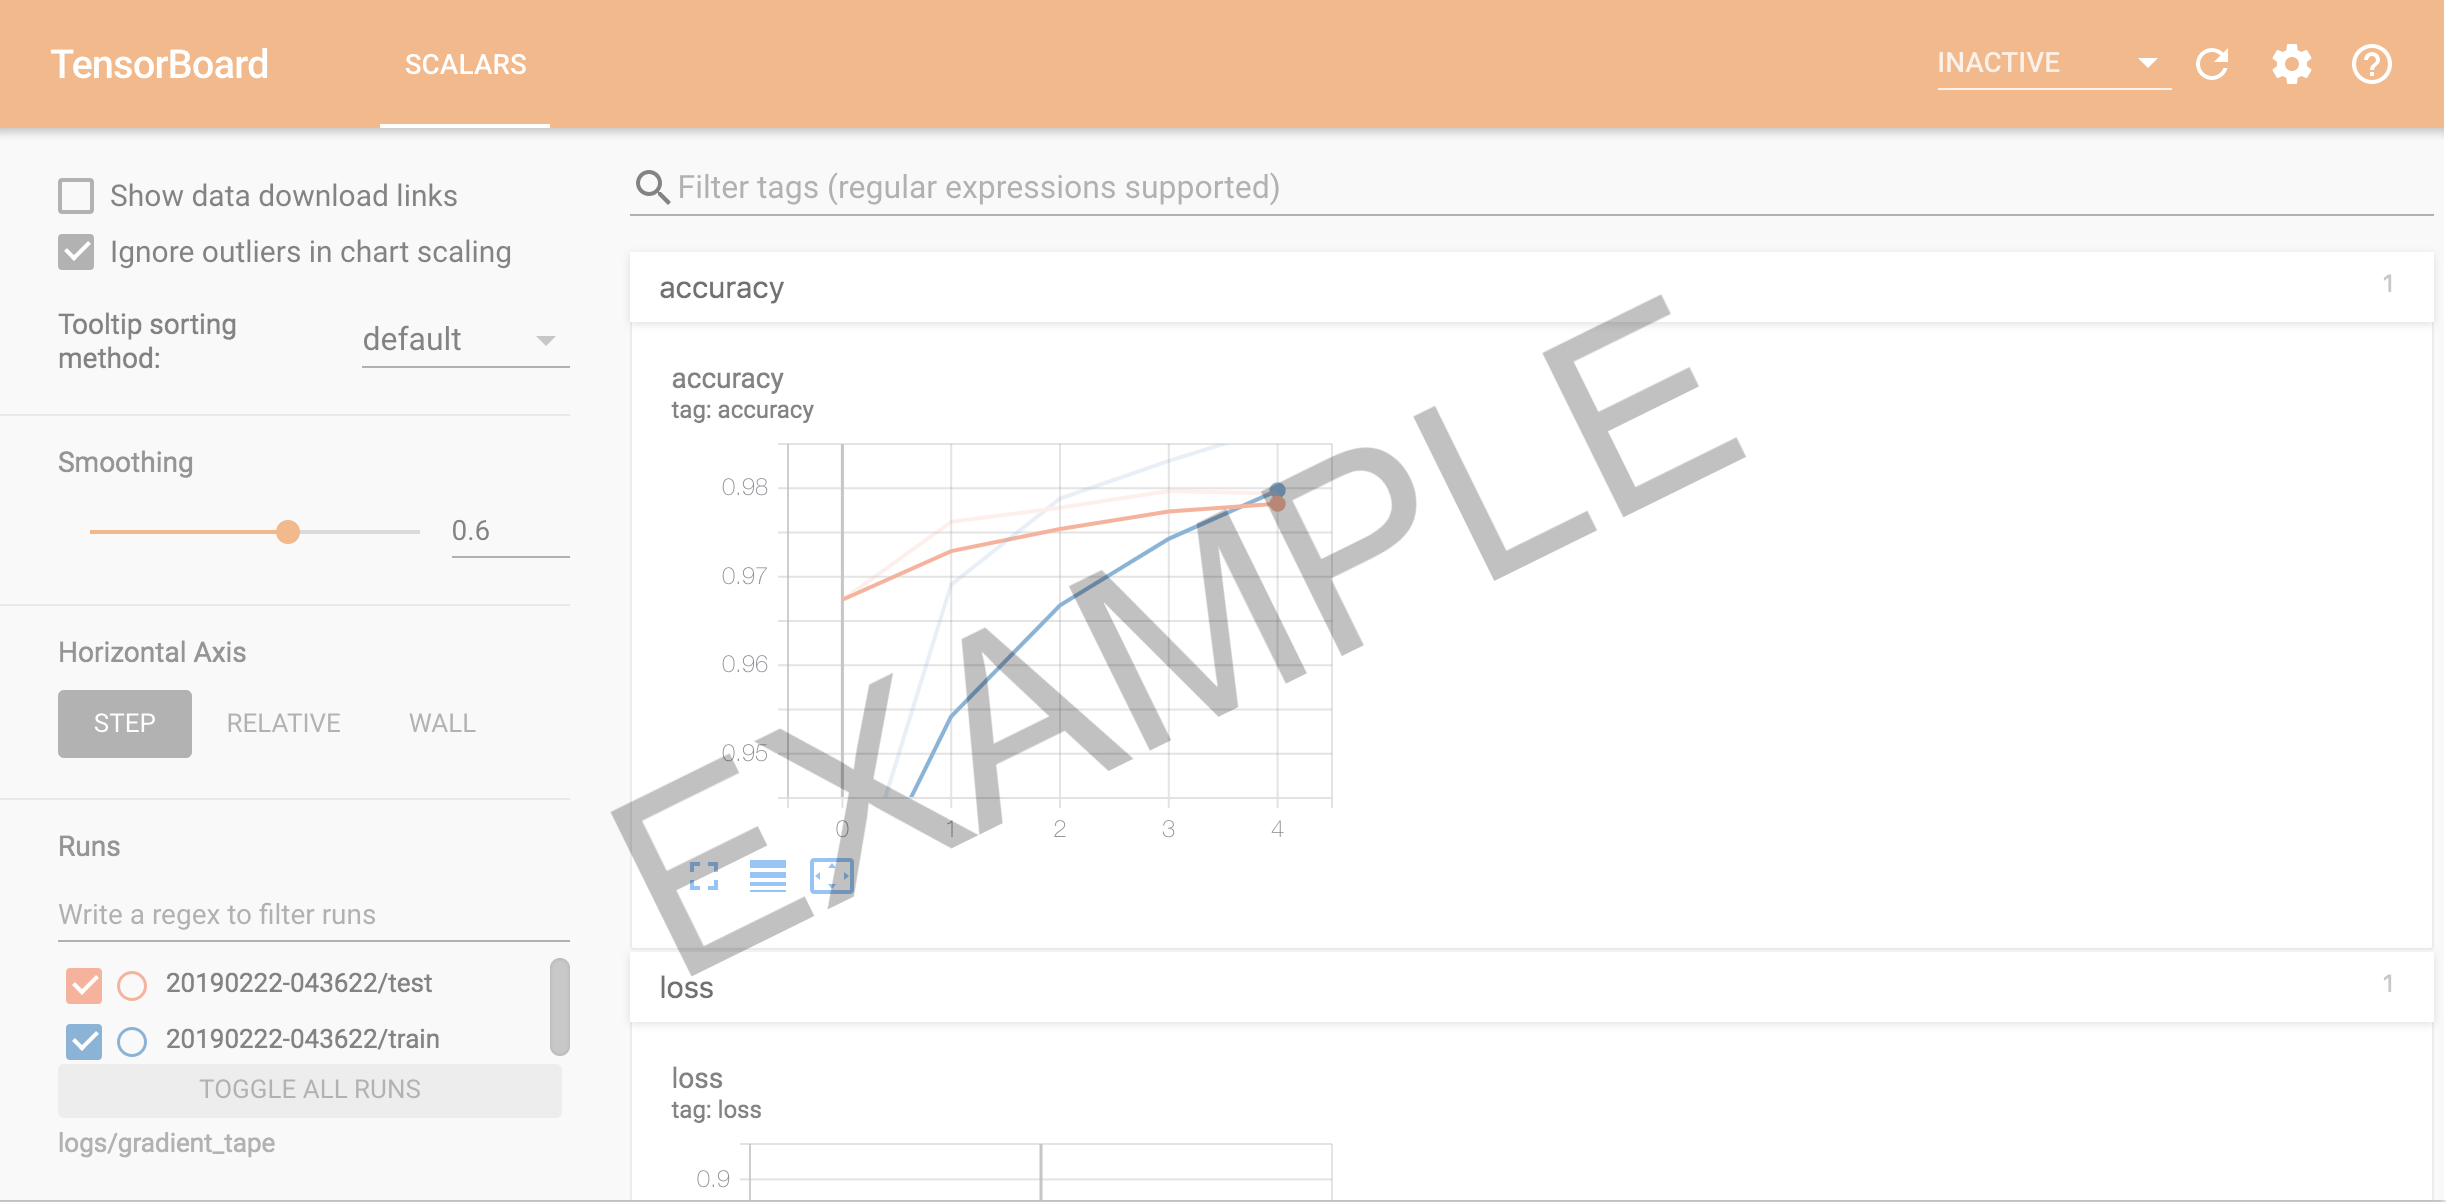

#### Configuring ClearML

1) Sign up in  [ClearMl](https://clear.ml)
2) Install clearml as python package: pip install clearml
3) Get [credentials](https://app.clear.ml/settings/workspace-configuration) to connect your notebook with remote server. When creating new credentials, pick Jupyter notebook tab.  
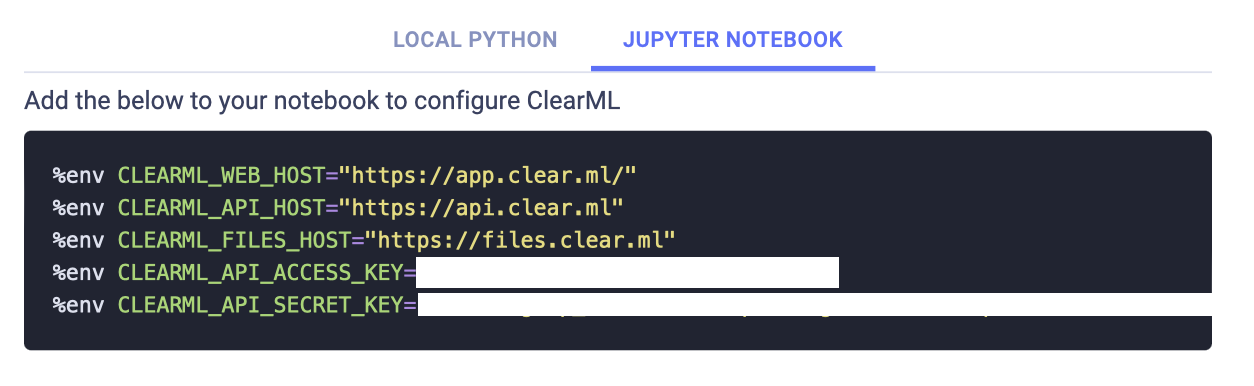
4) Put these env variables 
5) Run !clearml-init
6) Uncomment code in the next cell 

In [ ]:
# %pip install clearml
# !clearml-init


In [ ]:
# Run this cell to start monitoring the training
#from clearml import Task

#task = Task.init(task_name="classifier_training", project_name="lab2")

In [170]:
# try again and check Web UI...
"""
train(
    model=CNNClassificationModel(),
    optimizer=...,
    loss_fn=...,
    train_loader=train_loader,
    val_loader=val_loader,
    device='cpu',
    writer=SummaryWriter(),
    epochs=2
)
"""

cpu


Epoch 0:   0%|          | 0/166 [00:00<?, ?it/s]

Val:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/166 [00:00<?, ?it/s]

Val:   0%|          | 0/19 [00:00<?, ?it/s]

ClearMl results look like this

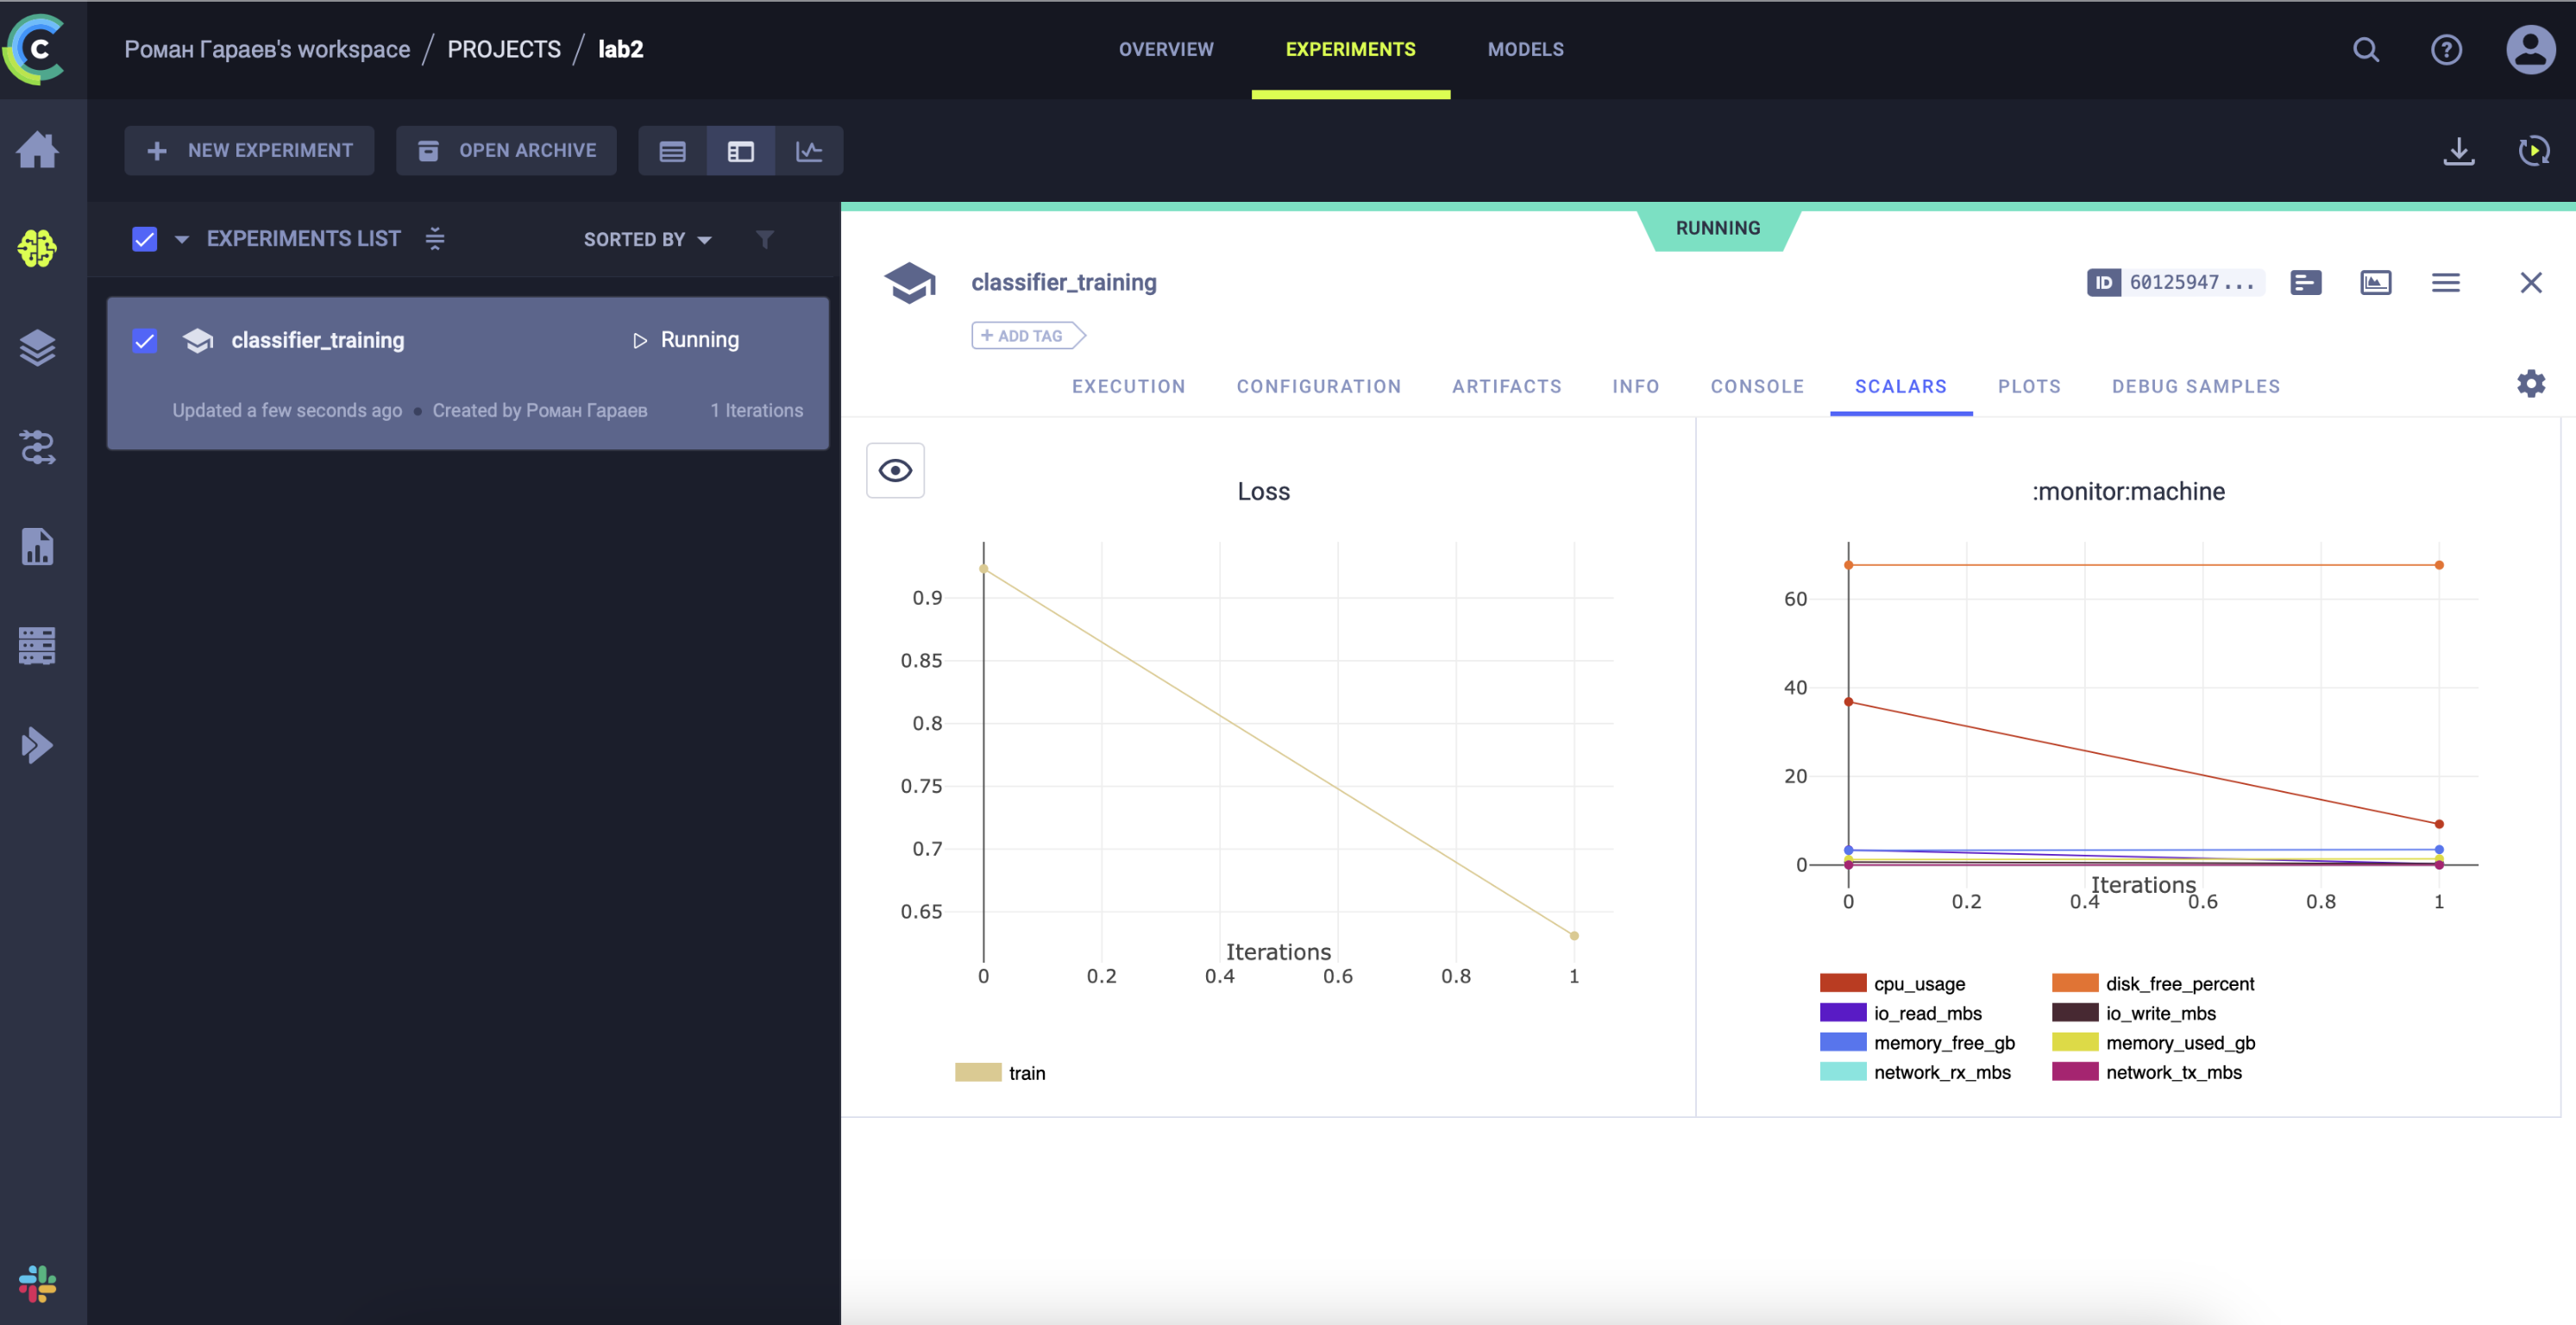